<a href="https://colab.research.google.com/github/Frederik-Roeckle/HFF_AT_Assignments/blob/master/WaveletDecompositonDataGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [57]:
!pip install pywavelets

In [83]:
import pandas as pd
import pywt
import shutil
import matplotlib.pyplot as plt

In [84]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/HFF_AT_Assignment_3/ustech100/ustech100_minute.txt", sep=", ", header=None)

<ipython-input-84-b889b309449a>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/HFF_AT_Assignment_3/ustech100/ustech100_minute.txt", sep=", ", header=None)


In [85]:
df.rename(columns={0: 'Datetime', 1: 'Midprice'}, inplace=True)
df["Midprice"] = df["Midprice"].str.replace(",", ".")
df["Midprice"] = df["Midprice"].astype("float")
df["Datetime"] = pd.to_datetime(df['Datetime'], format='%d.%m.%Y %H:%M:%S%f')
df.set_index("Datetime", inplace=True)
df.head()

,Midprice
Datetime,
2023-06-02 07:01:00,14481.0
2023-06-02 07:02:00,14483.4
2023-06-02 07:03:00,14480.0
2023-06-02 07:04:00,14481.3
2023-06-02 07:05:00,14481.4


In [86]:
# Slice dataframe by day since we dont want to trade over the end of the day
DF_list = [group[1] for group in  df.groupby([df.index.year,df.index.month,df.index.day])]
len(DF_list)

281

In [ ]:
# Prepare the time series
time_series = (DF_list[16].reset_index()).loc[240:479].Midprice
time_series_normalized = (time_series - time_series.mean()) / time_series.std()

# Parameters for CWT
sampling_rate = 1  # Minutely data
frequency_range = np.linspace(1, 50, 100)  # Define frequency range for CWT

# Perform Continuous Wavelet Transform (CWT)
wavelet = "cmor1.5-1.0"  # Complex Morlet wavelet
coefficients, frequencies = pywt.cwt(time_series_normalized, frequency_range, wavelet, sampling_rate)

# Plot the scalogram
plt.figure(figsize=(4, 4))
plt.imshow(np.abs(coefficients), extent=[0, len(time_series), frequency_range.min(), frequency_range.max()],
           aspect='auto', interpolation='bilinear', cmap='jet', vmin=0, vmax=np.percentile(np.abs(coefficients), 95))
plt.show()

By applying a continous wavelet transformation we achieve the following scaleogram:

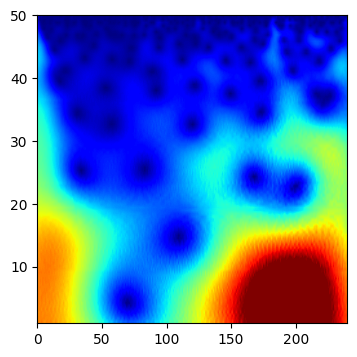

Parameters for the cwt and the visualisation of the scaleogram

In [91]:
window_size = 240                           # Window size for wavelet decomposition
wavelet = "cmor1.5-1.0"                     # Complex Morlet wavelet
sampling_rate = 1                           # Minutely data
frequency_range = np.linspace(1, 50, 100)   # Define frequency range for CWT
change_percent = 0                          # Define a threshold for change that needs to be crossed in order to count it as a real change
offset = 120                                 # Create more images by shifting the windows by an offset

folder_up = "/content/drive/MyDrive/Colab Notebooks/HFF_AT_Assignment_3/ustech100/data/up"
folder_down = "/content/drive/MyDrive/Colab Notebooks/HFF_AT_Assignment_3/ustech100/data/down"
folder_no_change = "/content/drive/MyDrive/Colab Notebooks/HFF_AT_Assignment_3/ustech100/data/no_change"

Iterating over each day and comute the cwt and the corresponding scaleogram. Depending on the price development it is stored in the respective folder.

In [ ]:
for day in range(0,len(DF_list)-1): # over all days
  for i in range(0, 5): # build 5 blocks per day
    try:
      day_series = DF_list[day].reset_index()
      time_series = (DF_list[day].reset_index()).loc[(i*window_size)+offset:((i+1)*window_size-1)+offset].Midprice
      time_series_normalized = (time_series - time_series.mean()) / time_series.std()

      # Check if price goes up or down after the end of the period
      direction = ""
      print("value at time: " + str(day_series.iloc[((i+1)*window_size-1)+offset].Midprice) + " and at time + 1: " + str(day_series.iloc[((i+1)*window_size)+offset].Midprice))
      if day_series.iloc[((i+1)*window_size-1)+offset].Midprice < day_series.iloc[((i+1)*window_size)+offset].Midprice:
        direction = "up"
        print("up")
      elif day_series.iloc[((i+1)*window_size-1)+offset].Midprice > day_series.iloc[((i+1)*window_size)+offset].Midprice:
        direction = "down"
        print("down")
      else:
        print("no change")
        direction = "no change"

      # Perform Continuous Wavelet Transform (CWT)
      coefficients, frequencies = pywt.cwt(time_series_normalized, frequency_range, wavelet, sampling_rate)

      # Save image
      filename = str(day) + "_" + str(i) + "_shifted_" +str(offset) + "_" + direction + ".png"
      plt.figure(figsize=(4, 4))
      plt.imshow(np.abs(coefficients), extent=[0, len(time_series), frequency_range.min(), frequency_range.max()],
                aspect='auto', interpolation='bilinear', cmap='jet', vmin=0, vmax=np.percentile(np.abs(coefficients), 95))
      if direction == "up":
        path = folder_up + "/" + filename
        plt.savefig(path)
        plt.close()
      elif direction == "down":
        path = folder_down + "/" + filename
        plt.savefig(path)
        plt.close()
      else:
        path = folder_no_change + "/" + filename
        plt.savefig(path)
        plt.close()
    except ValueError:
      print("Value Error")
      pass
    except IndexError:
      print("Index Error")
      pass
